<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>

## Специализация "Машинное обучение и анализ данных"
## Неделя 7. Финальный проект

</center>

## Общие сведения
<div>
  <figcaption>
      <br><b>Автор работы:</b> 
      Ооржак Александр Юрьевич
    </figcaption>
</div>
<div>
    <div><b>Цель проекта:</b> Идентификация пользователя по последовательности из нескольких посещенных подряд им сайтов.</div>
    <div><b>Практическое применение:</b> Возможность выявлять взлом аккаунта пользователя или его индентифицикация по логам посещения сайтов.</div>
    <div><b>Описание исходных данных:</b> Имеются данные <a href="https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2">соревнований</a> Kaggle, а именно:<br></div>
    
 - pickle-файл **site_dic.pkl** словарь сайтов формата {'site_string': site_id};
 - **train_session.csv** обучающая выборка с признаками: site_i – это индексы посещенных сайтов (расшифровка дана в pickle-файле со словарем site_dic.pkl); time_j – время посещения сайтов site_j; целевой признак target – факт того, что сессия принадлежит Элис (то есть, что именно Элис ходила по всем этим сайтам);
 - **test_session.csv** тестовая выборка по которой нужно сделать прогноз, принадлежит ли сессия Элис;
 - папка train с csv-файлами для Alice и других пользователей с названием user****.csv (где вместо звездочек – 4 цифры, соответствующие ID пользователя). В файлах содержится информация о посещениях сайтов соответствующим пользователем в следующем формате: <br>

<center>user0001.csv</center>
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-yw4l{vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-031e">timestamp</th>
    <th class="tg-031e">site</th>
  </tr>
  <tr>
    <td class="tg-031e">00:00:01</td>
    <td class="tg-031e">vk.com</td>
  </tr>
  <tr>
    <td class="tg-yw4l">00:00:11</td>
    <td class="tg-yw4l">google.com</td>
  </tr>
  <tr>
    <td class="tg-031e">00:00:16</td>
    <td class="tg-031e">vk.com</td>
  </tr>
  <tr>
    <td class="tg-031e">00:00:20</td>
    <td class="tg-031e">yandex.ru</td>
  </tr>
</table>
    
Детали:
- Сессии пользователей выделены таким образом, что они не могут быть длинее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд, либо когда сессия заняла по времени более 30 минут.


## Порядок работы:

<ul>
    <li>первичный анализ признаков;</li>
    <li>описание предобработки данных;</li>
    <li>добавление новых признаков;</li>
    <li>визуальный анализ данных;</li>
    <li>обучение моделей;</li>
    <li>оценка модели;</li>
    <li>выводы.</li>
</ul>

### 1) Первичный анализ данных и их предобработка

In [2]:
%load_ext watermark
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn

CPython 3.7.6
IPython 7.12.0

numpy 1.18.1
scipy 1.4.1
pandas 1.0.1
matplotlib 3.1.3
statsmodels 0.11.0
sklearn 0.22.1

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores  : 6
interpreter: 64bit


In [ ]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import re
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
from tqdm import tqdm, tqdm_notebook
import collections

In [172]:
# Путь к данным
PATH_TO_DATA = 'capstone_user_identification\\'
#Структура папка с данными
l_f = os.walk(PATH_TO_DATA)
print('Структура папки с данными \n')
for i,j in enumerate(l_f):
    print('Папка '+ str(i) +': ' + j[0])

Структура папки с данными 

Папка 0: capstone_user_identification\
Папка 1: capstone_user_identification\train
Папка 2: capstone_user_identification\train\10users
Папка 3: capstone_user_identification\train\other_user_logs


Посмотрим на подготовленный словарь индексов сайтов

In [5]:
with open(os.path.join(PATH_TO_DATA,'site_dic.pkl'), 'rb') as SFD_pkl:
        SiteDict = pickle.Unpickler(SFD_pkl).load()

In [8]:
sort_dict = dict(sorted(SiteDict.items(), key=lambda item: item[1]))
sort_dict

{'fpdownload2.macromedia.com': 1,
 'hotmail.fr': 2,
 'login.live.com': 3,
 'mail.live.com': 4,
 'dub122.mail.live.com': 5,
 'people.directory.live.com': 6,
 'secure.shared.live.com': 7,
 'windowslive.tt.omtrdc.net': 8,
 'cid-1bed360223325286.users.storage.live.com': 9,
 'js.live.net': 10,
 'go.trouter.io': 11,
 'storage.live.com': 12,
 'blufiles.storage.msn.com': 13,
 'h.live.com': 14,
 'prod.registrar.skype.com': 15,
 'api.skype.com': 16,
 'proxy-bay-people.directory.live.com': 17,
 'p.sfx.ms': 18,
 'dub122.afx.ms': 19,
 'google.fr': 20,
 'www.google.fr': 21,
 'apis.google.com': 22,
 'www.google.com': 23,
 'lipsakiss.free.fr': 24,
 'www.shotgun2013.fr': 25,
 'ba.commentcamarche.net': 26,
 'www.commentcamarche.net': 27,
 'static.commentcamarche.net': 28,
 'www.facebook.com': 29,
 'platform.twitter.com': 30,
 'static.ccm2.net': 31,
 'connect.facebook.net': 32,
 'static.ak.facebook.com': 33,
 'r.ccm2.net': 34,
 's-static.ak.facebook.com': 35,
 'static.ccmbg.com': 36,
 'twitter.com': 37,


In [9]:
print("Минимальный индекс сайта: %.i" % min(SiteDict.values()))
print("Максимальный индекс сайта: %.i" % max(SiteDict.values()))
print("Количество сайтов: %.i" % len(SiteDict.values()))

Минимальный индекс сайта: 1
Максимальный индекс сайта: 48371
Количество сайтов: 48371


Считаем данные обучающей и тестовой выборок

In [10]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

In [11]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   site1   253561 non-null  int64  
 1   time1   253561 non-null  object 
 2   site2   250098 non-null  float64
 3   time2   250098 non-null  object 
 4   site3   246919 non-null  float64
 5   time3   246919 non-null  object 
 6   site4   244321 non-null  float64
 7   time4   244321 non-null  object 
 8   site5   241829 non-null  float64
 9   time5   241829 non-null  object 
 10  site6   239495 non-null  float64
 11  time6   239495 non-null  object 
 12  site7   237297 non-null  float64
 13  time7   237297 non-null  object 
 14  site8   235224 non-null  float64
 15  time8   235224 non-null  object 
 16  site9   233084 non-null  float64
 17  time9   233084 non-null  object 
 18  site10  231052 non-null  float64
 19  time10  231052 non-null  object 
 20  target  253561 non-null  int64  
dtypes: float64

In [13]:
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


In [14]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82797 entries, 1 to 82797
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   site1   82797 non-null  int64  
 1   time1   82797 non-null  object 
 2   site2   81308 non-null  float64
 3   time2   81308 non-null  object 
 4   site3   80075 non-null  float64
 5   time3   80075 non-null  object 
 6   site4   79182 non-null  float64
 7   time4   79182 non-null  object 
 8   site5   78341 non-null  float64
 9   time5   78341 non-null  object 
 10  site6   77566 non-null  float64
 11  time6   77566 non-null  object 
 12  site7   76840 non-null  float64
 13  time7   76840 non-null  object 
 14  site8   76151 non-null  float64
 15  time8   76151 non-null  object 
 16  site9   75484 non-null  float64
 17  time9   75484 non-null  object 
 18  site10  74806 non-null  float64
 19  time10  74806 non-null  object 
dtypes: float64(9), int64(1), object(10)
memory usage: 13.3+ MB


**Посмотрим на сбалансированность выборки по классам**

In [15]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

В обучающей выборке – 2297 сессий одного пользователя (Alice) и 251264 сессий – других пользователей, не Элис. Дисбаланс классов очень сильный и смотреть на долю верных ответов (accuracy) непоказательно.

#### Объединим обучающую и тестовую выборку **train_test_df**

In [16]:
train_test_df = pd.concat([train_df, test_df])

Размерность матрицы

In [45]:
train_test_df.shape

(336358, 21)

Выделим данные по посещению сайтов.

Индексы нумеровались с 1 (см. SiteDic), так что заменим пропуски на нули.

In [17]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

In [18]:
train_test_df_sites.head(10)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0
2,890,941,3847,941,942,3846,3847,3846,1516,1518
3,14769,39,14768,14769,37,39,14768,14768,14768,14768
4,782,782,782,782,782,782,782,782,782,782
5,22,177,175,178,177,178,175,177,177,178
6,570,21,570,21,21,0,0,0,0,0
7,803,23,5956,17513,37,21,803,17514,17514,17514
8,22,21,29,5041,14422,23,21,5041,14421,14421
9,668,940,942,941,941,942,940,23,21,22


In [46]:
train_test_df_time = train_test_df[['time%d' % i for i in range(1, 11)]]

In [47]:
train_test_df_time.head(10)

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
session_id,,,,,,,,,,
1,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-02-22 11:19:50,2014-02-22 11:19:50,2014-02-22 11:19:51,2014-02-22 11:19:51,2014-02-22 11:19:51,2014-02-22 11:19:51,2014-02-22 11:19:52,2014-02-22 11:19:52,2014-02-22 11:20:15,2014-02-22 11:20:16
3,2013-12-16 16:40:17,2013-12-16 16:40:18,2013-12-16 16:40:19,2013-12-16 16:40:19,2013-12-16 16:40:19,2013-12-16 16:40:19,2013-12-16 16:40:20,2013-12-16 16:40:21,2013-12-16 16:40:22,2013-12-16 16:40:24
4,2014-03-28 10:52:12,2014-03-28 10:52:42,2014-03-28 10:53:12,2014-03-28 10:53:42,2014-03-28 10:54:12,2014-03-28 10:54:42,2014-03-28 10:55:12,2014-03-28 10:55:42,2014-03-28 10:56:12,2014-03-28 10:56:42
5,2014-02-28 10:53:05,2014-02-28 10:55:22,2014-02-28 10:55:22,2014-02-28 10:55:23,2014-02-28 10:55:23,2014-02-28 10:55:59,2014-02-28 10:55:59,2014-02-28 10:55:59,2014-02-28 10:57:06,2014-02-28 10:57:11
6,2014-03-18 15:18:31,2014-03-18 15:18:39,2014-03-18 15:23:02,2014-03-18 15:23:43,2014-03-18 15:29:57,NaN,NaN,NaN,NaN,NaN
7,2014-02-13 16:45:35,2014-02-13 16:45:35,2014-02-13 16:45:35,2014-02-13 16:45:35,2014-02-13 16:46:05,2014-02-13 16:47:14,2014-02-13 16:47:14,2014-02-13 16:47:15,2014-02-13 16:47:16,2014-02-13 16:47:17
8,2013-04-12 10:27:26,2013-04-12 10:27:26,2013-04-12 10:27:28,2013-04-12 10:27:29,2013-04-12 10:27:29,2013-04-12 10:27:29,2013-04-12 10:27:29,2013-04-12 10:27:31,2013-04-12 10:27:31,2013-04-12 10:27:32
9,2014-03-17 16:23:08,2014-03-17 16:23:35,2014-03-17 16:23:35,2014-03-17 16:23:35,2014-03-17 16:23:36,2014-03-17 16:23:36,2014-03-17 16:23:36,2014-03-17 16:23:52,2014-03-17 16:23:52,2014-03-17 16:23:53


In [328]:
def reduce_mem_usage (df):
    for col in df.columns:
        df[col] = pd.to_datetime(df[col])
    return df

Преобразуем тип с временными метками в datetime

In [329]:
train_test_df_time = reduce_mem_usage(train_test_df_time)
train_test_df_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336358 entries, 1 to 82797
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   time1   336358 non-null  datetime64[ns]
 1   time2   331406 non-null  datetime64[ns]
 2   time3   326994 non-null  datetime64[ns]
 3   time4   323503 non-null  datetime64[ns]
 4   time5   320170 non-null  datetime64[ns]
 5   time6   317061 non-null  datetime64[ns]
 6   time7   314137 non-null  datetime64[ns]
 7   time8   311375 non-null  datetime64[ns]
 8   time9   308568 non-null  datetime64[ns]
 9   time10  305858 non-null  datetime64[ns]
dtypes: datetime64[ns](10)
memory usage: 28.2 MB


Так как словарь сайтов приведен для всех пользователей, посмотрим на **общее количество посещений уникальных сайтов отдельно для пользователя Alice**

In [81]:
site_i_all_alice = np.reshape(train_df[['site%d' % i for i in range(1, 11)]+["target"]].
                              fillna(0).astype('int')[train_df['target']==1].values, (1,-1))[0]

In [87]:
freq_sites_alice = dict(sorted(collections.Counter(site_i_all_alice).items(), key=lambda item: item[1], reverse=True))

***Для наглядности частоты посещаемости сайтов Alice построим интерактивную столбчатую диаграмму с помощью библиотеки plotly для первых 30 сайтов по частоте посещения Alice***

In [90]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [170]:
data_viz =  go.Bar(
    x = [list(sort_dict.keys())[x-1] for x in list(freq_sites_alice.keys())[:30]],
    y = list(freq_sites_alice.values())[:30]
)

fig = go.Figure(data = data_viz)
fig.update_layout(width=900, height=600)
fig.update_xaxes(tickangle=-90)
fig.update_layout(xaxis_title='Index sites', yaxis_title=u'Количество посещений')
iplot(fig)

Список первых по посещаемости Alice 30 сайтов 

In [96]:
freq_sites_alice

{1: 2309,
 77: 1382,
 80: 1354,
 76: 1307,
 29: 897,
 21: 857,
 81: 609,
 22: 522,
 879: 522,
 75: 451,
 82: 447,
 23: 437,
 35: 381,
 881: 371,
 37: 293,
 33: 291,
 3000: 286,
 733: 274,
 30: 272,
 78: 236,
 941: 215,
 7832: 209,
 52: 206,
 704: 204,
 0: 201,
 2078: 188,
 617: 159,
 1057: 155,
 942: 153,
 270: 151,
 335: 150,
 12619: 150,
 855: 143,
 3: 129,
 1514: 126,
 3559: 125,
 3560: 124,
 265: 123,
 39: 121,
 2077: 121,
 1515: 110,
 32: 109,
 229: 106,
 14: 100,
 38: 98,
 616: 98,
 1307: 93,
 106: 82,
 940: 81,
 99: 81,
 8: 80,
 1517: 73,
 2080: 71,
 17283: 69,
 896: 69,
 677: 68,
 263: 68,
 27307: 68,
 1521: 67,
 143: 67,
 2079: 66,
 1519: 66,
 1516: 63,
 1518: 61,
 25383: 58,
 1520: 57,
 5392: 56,
 1524: 55,
 1523: 54,
 268: 53,
 27189: 53,
 1345: 52,
 5396: 51,
 167: 50,
 3846: 49,
 3847: 49,
 11: 48,
 6088: 46,
 2401: 46,
 11241: 44,
 51: 44,
 5402: 42,
 397: 40,
 876: 40,
 2081: 40,
 5400: 37,
 2372: 37,
 5403: 36,
 2271: 36,
 1919: 36,
 3517: 36,
 559: 35,
 6: 35,
 5397: 3

In [212]:
list(zip(list(freq_sites_alice.keys())[:30], [list(sort_dict.keys())[x-1] for x in list(freq_sites_alice.keys())[:30]]))

[(1, 'fpdownload2.macromedia.com'),
 (77, 'i1.ytimg.com'),
 (80, 's.youtube.com'),
 (76, 'www.youtube.com'),
 (29, 'www.facebook.com'),
 (21, 'www.google.fr'),
 (81, 'r4---sn-gxo5uxg-jqbe.googlevideo.com'),
 (22, 'apis.google.com'),
 (879, 'r1---sn-gxo5uxg-jqbe.googlevideo.com'),
 (75, 's.ytimg.com'),
 (82, 'r2---sn-gxo5uxg-jqbe.googlevideo.com'),
 (23, 'www.google.com'),
 (35, 's-static.ak.facebook.com'),
 (881, 'r3---sn-gxo5uxg-jqbe.googlevideo.com'),
 (37, 'twitter.com'),
 (33, 'static.ak.facebook.com'),
 (3000, 'vk.com'),
 (733, 'translate.google.fr'),
 (30, 'platform.twitter.com'),
 (78, 'yt3.ggpht.com'),
 (941, 'mts0.google.com'),
 (7832, 'www.info-jeunes.net'),
 (52, 'clients1.google.com'),
 (704, 'www.audienceinsights.net'),
 (0, 'meance.eric.perso.neuf.fr'),
 (2078, 'www.melty.fr'),
 (617, 'gg.google.com'),
 (1057, 'plus.googleapis.com'),
 (942, 'mts1.google.com'),
 (270, 'api.bing.com')]

## 2) Добавление новых признаков и визуальный анализ

**Посмотрим распределение числа уникальных сайтов в каждой сессии из 10 посещенных подряд сайтов по всей объединенной выборке.**

In [20]:
%%time
unique_sites = train_test_df_sites.apply(np.unique, axis=1)
unique_sites = unique_sites.apply(len)

Wall time: 23.6 s


Постройте гистограмму распределения числа уникальных сайтов в сессии

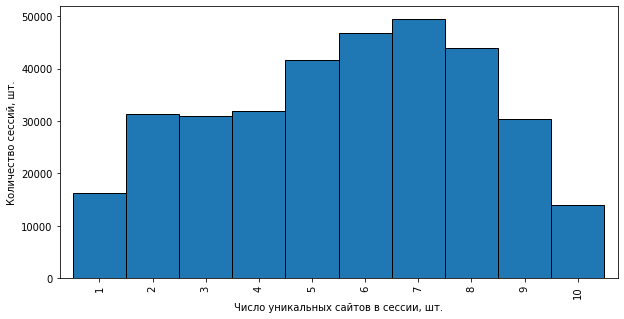

In [161]:
fig, axes = plt.subplots(figsize=(10, 5))

plt.xlabel(u'Число уникальных сайтов в сессии, шт.')
plt.ylabel(u'Количество сессий, шт.')
unique_sites.value_counts().sort_index().plot.bar(width=1, edgecolor='black')

In [32]:
print("Shapiro-Wilk normality test, W-statistic: %f, p-value: %.02f" % stats.shapiro(unique_sites))

Shapiro-Wilk normality test, W-statistic: 0.957864, p-value: 0.00


Из проверки нулевой гипотезы $H_0$ следует, что рассматриваемые данные не распределены нормально.

Рассмотрим данное распределения отдельно для всех пользователей и Alice на обучающей выборке

Для добавления новых признаков в обучающую и тестовую выборки, которые могут помочь в идентификации пользователя, проведем визуальный анализ создаваемых признаков на выборке из 10 пользователей (один из них будет являтся нашей Alice).<br>
Так как обучающая выборка представляет собой данные, подготовленные к задаче классификации "ALICE-vs-ALL", где в столбце *target* обозначен только индентифицируемуй пользователь Alice, использовать ее для визуального анализа признаков по другим пользователям не представляется возможным. 

Таким образом, в первую очередь необходимо разработать функцию предобработки данных из логов пользователей (файлов формата csv из папки train), которая на выходе будет выдавать аналогичный обучающей выборке массив данных с признаками: *site_i* – это индексы посещенных сайтов (расшифровка дана в pickle-файле со словарем site_dic.pkl), производными от них и производными от *time_j* – время посещения сайтов site_j. Помимо данной информации, каждая строка массива будет содержать информацию о пользователе, к которому она принадлежит.

В будущем при подготовке данных к обучению и тесту, столбцы о посещениях сайтов site1...site10 будут преобразованы в разреженную матрицу, где в строках будут указаны сессии, а в столбцах индексы всех сайтов, так как анализ по самим индексам сайтов бессмысленен.

***Создадим feature_engineering добавим следующие новые признаки:***
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `dayofweek` – день недели начала сессии (то есть день недели в записи минимального timestamp среди десяти)
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `#unique_sites` – число уникальных сайтов в сессии
- `aver_time_top_site_30` - среднее время пребывания на сайте для топ-30 популярных сайтов
- `freq_soc_top_site` - суммарная посещаемость сайтов 's.youtube.com'(80), 'www.youtube.com'(76), 'www.facebook.com'(29), 'www.google.fr'(21), 'twitter.com'(37), 'vk.com'(3000) в сессию (данные сайты входят в топ-30 сайтов по посещяемости Alice)

In [247]:
def feature_engineering(path_to_csv_files, site_freq_path, session_length=10, window_size=10,
                        features = ['site_' + str(j) for j in range(1,11)] + \
                        ['session_timespan','dayofweek', 'start_hour','#unique_sites'] + \
                        ['aver_time_top_site_30', 'freq_soc_top_sit', 'user']):
    
    with open(site_freq_path, 'rb') as SFD_pkl:
        Site_Freq_Dict = pickle.Unpickler(SFD_pkl).load()
  
    l = glob(path_to_csv_files+'/*.csv')
    ListDataRes = []
    
    for NameCsvFile in tqdm(l):
        user_x = pd.read_csv(NameCsvFile, header = 0, index_col = 0, parse_dates = True)
        user_x['index_site'] = user_x['site'].map(lambda x: Site_Freq_Dict[x])
        
        k = 0
        ListData = []

        while (k*window_size) < len(user_x):
            ListData.append([])
            sum_time_top_site_30 = 0
            count_top_site_30 = 0
            freq_soc_top_site = 0
            #заполнение каждой сессии номерами сайтов из общего частотного словаря
            for j in range(session_length):
                if (k*window_size+j) < len(user_x):
                    ListData[k].append(user_x['index_site'][k*window_size+j])
                    if user_x['index_site'][k*window_size+j] in range(1,31):
                        if user_x['index_site'][k*window_size+j] in range(1,31):
                            count_top_site_30 +=1
                        if k*window_size+j+1 < len(user_x):
                            if user_x['index_site'][k*window_size+j] in range(1,31):
                                sum_time_top_site_30+=pd.Timedelta(user_x.iloc[k*window_size+j+1].name
                                                    -user_x.iloc[k*window_size+j].name).seconds 
                    if user_x['index_site'][k*window_size+j] in [21, 29, 37, 76, 80, 300]:       
                        freq_soc_top_site += 1
                else:
                    ListData[k].append(0)
            
            if (k*window_size+session_length) <= len(user_x):
                #вычисление продолжительности сессии session_timespan и ее добавление после списка сайтов
                ListData[k].append(pd.Timedelta(user_x.iloc[k*window_size+session_length-1].name
                                                -user_x.iloc[k*window_size].name).seconds)
                #dayofweek день недели начала сессии            
                ListData[k].append(user_x.iloc[k*window_size].name.weekday())
                #start_hour час начала сессии
                ListData[k].append(user_x.iloc[k*window_size].name.hour)
                #unique_sites добавление числа уникальных сайтов в сессии
                ListData[k].append(user_x['index_site'][k*window_size:(k*window_size+session_length)].unique().size)                                   
            else:
                #вычисление продолжительности сессии session_timespan и ее добавление после списка сайтов
                ListData[k].append(pd.Timedelta(user_x.iloc[-1].name
                                                -user_x.iloc[k*window_size].name).seconds)
                #dayofweek день недели начала сессии            
                ListData[k].append(user_x.iloc[k*window_size].name.weekday())
                #start_hour час начала сессии
                ListData[k].append(user_x.iloc[k*window_size].name.hour)
                #unique_sites добавление числа уникальных сайтов в сессии
                ListData[k].append(user_x['index_site'][k*window_size:len(user_x)].unique().size)
            
            #aver_time_top_site_30 - среднее время пребывания на сайте для топ-30 популярных сайтов
            #freq_soc_top_site - суммарная посещаемость сайтов 's.youtube.com'(80), 'www.youtube.com'(76), 
            #'www.facebook.com'(29), 'www.google.fr'(21), 'twitter.com'(37), 'vk.com'(3000)
            if count_top_site_30 != 0:
                ListData[k].append(sum_time_top_site_30/count_top_site_30)
                ListData[k].append(freq_soc_top_site)
            else:                       
                ListData[k].append(0)
                ListData[k].append(freq_soc_top_site)                   
 
            #добавление имени юзера
            ListData[k].append(re.search(r'\\train\\10users\\(.*?).csv', NameCsvFile).group(1))
            k+=1
            
        ListDataRes += ListData
        
    DataRes = pd.DataFrame(ListDataRes, columns=features)

    return DataRes

In [248]:
%%time
new_train_data_10users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         'train\\10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_dic.pkl'))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.18it/s]

Wall time: 8.47 s


In [249]:
new_train_data_10users

,site_1,site_2,site_3,site_4,site_5,site_6,site_7,site_8,site_9,site_10,session_timespan,dayofweek,start_hour,#unique_sites,aver_time_top_site_30,freq_soc_top_sit,user
0,270,270,270,21,21,7832,21,7832,30,7832,437,1,16,4,3.750000,3,Alice_log
1,29,7832,37,7832,7832,29,7832,29,7832,7832,26,1,16,3,5.666667,4,Alice_log
2,29,7832,7832,29,37,7832,29,7832,29,270,53,1,16,4,10.250000,5,Alice_log
3,167,167,1515,167,37,1514,855,1515,855,1514,3,1,16,5,0.000000,1,Alice_log
4,1516,1515,1514,1518,1521,1523,1519,1524,1517,855,0,1,16,10,0.000000,0,Alice_log
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3881,1098,1098,1098,1098,21,1098,1098,1098,1098,1098,381,2,11,2,46.000000,1,user0022
3882,1098,1098,1098,1098,1098,1098,1098,1098,1098,1098,95,2,11,1,0.000000,0,user0022
3883,1098,1098,1098,1098,1098,1098,305,718,270,306,925,2,11,5,0.000000,0,user0022
3884,717,720,721,719,1098,1098,1098,1098,1098,1098,121,2,11,5,0.000000,0,user0022


Перечень пользовательских id для визуального анализа данных

In [251]:
new_train_data_10users.user.unique()

array(['Alice_log', 'user0002', 'user0010', 'user0011', 'user0015',
       'user0017', 'user0018', 'user0019', 'user0020', 'user0022'],
      dtype=object)

**Визуальный анализ создаваемых признаков**

Построим гистограмму распределения длины сессии в секундах (*session_timespan*). <br>
Ограничем по *x* значением 200 (иначе слишком тяжелый хвост)

In [266]:
color_dic = {0: 'darkviolet', 1: 'aqua'}

In [280]:
data_alice = new_train_data_10users[new_train_data_10users['user']=='Alice_log']
data_another = new_train_data_10users[new_train_data_10users['user']!='Alice_log']

Text(0, 0.5, 'Количество сессий, шт.')

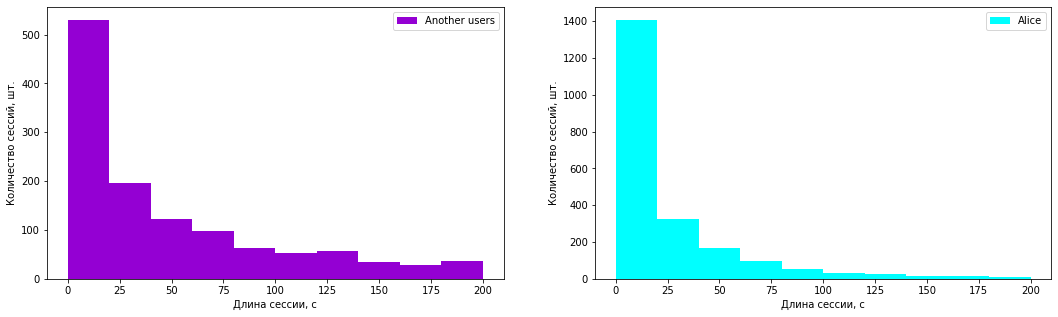

In [281]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 5))

axes[0].hist(data_another['session_timespan'].loc[data_another['session_timespan'] <= 200], 
                                color = color_dic[0], label="Another users")
axes[0].legend()
axes[0].set_xlabel(u'Длина сессии, с')
axes[0].set_ylabel(u'Количество сессий, шт.')

axes[1].hist(data_alice['session_timespan'].loc[data_alice['session_timespan'] <= 200], 
                                color = color_dic[1], label="Alice")
axes[1].legend()
axes[1].set_xlabel(u'Длина сессии, с')
axes[1].set_ylabel(u'Количество сессий, шт.')

Для каждого пользователя зададим свой цвет при построении графиков

In [282]:
color_dic = {'Alice_log': 'aqua', 'user0002': 'pink', 'user0010': 'firebrick', 'user0011':'blueviolet', 
             'user0015': 'hotpink', 'user0017': 'orchid', 
             'user0018': 'brown', 'user0020': 'gold', 'user0022': 'forestgreen', 
             'user0019': 'slategrey'}

Построим гистограммы распределения длины сессии (session_timespan) для каждого из 10 пользователей по отдельности, ограничев по x значением до 200 с

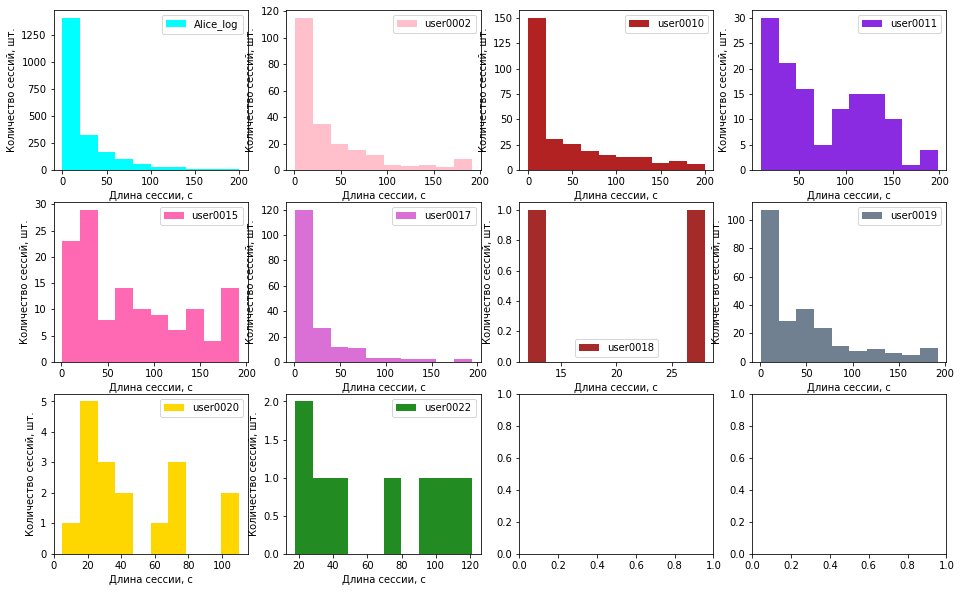

In [291]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.DataFrame.groupby(new_train_data_10users, 'user')): 
    axes[idx // 4][idx % 4].hist(sub_df['session_timespan'].loc[sub_df['session_timespan'] <= 200], 
                                color = color_dic[user], label = user)
    axes[idx // 4][idx % 4].set_xlabel(u'Длина сессии, с')
    axes[idx // 4][idx % 4].set_ylabel(u'Количество сессий, шт.')
    axes[idx // 4][idx % 4].legend()

Построим гистограммы распределения дня недели, в который началась сессия (day_of_week) для каждого из 10 пользователей по отдельности

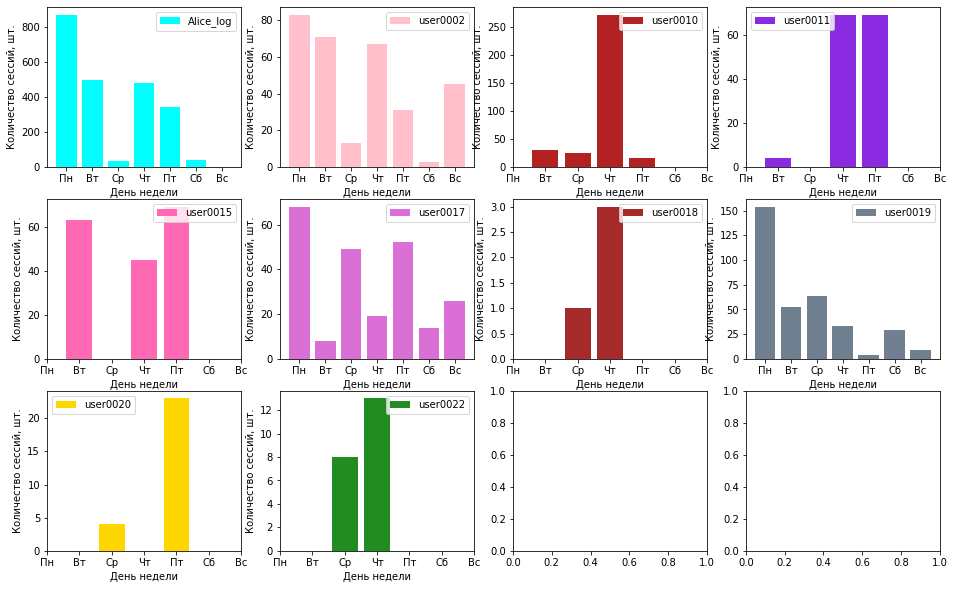

In [289]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))
days_of_week = [u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс']

for idx, (user, sub_df) in  enumerate(pd.DataFrame.groupby(new_train_data_10users, 'user')): 
    axes[idx // 4][idx % 4].bar(sub_df['dayofweek'].value_counts().index, sub_df['dayofweek'].value_counts(), 
                                color = color_dic[user], label = user)
    axes[idx // 4][idx % 4].set_xlabel(u'День недели')
    axes[idx // 4][idx % 4].set_ylabel(u'Количество сессий, шт.')
    axes[idx // 4][idx % 4].set_xticks(range(7))
    axes[idx // 4][idx % 4].set_xticklabels(days_of_week)
    axes[idx // 4][idx % 4].legend()

Построим гистограммы распределения часа начала сессии (start_hour) для каждого из 10 пользователей по отдельности.

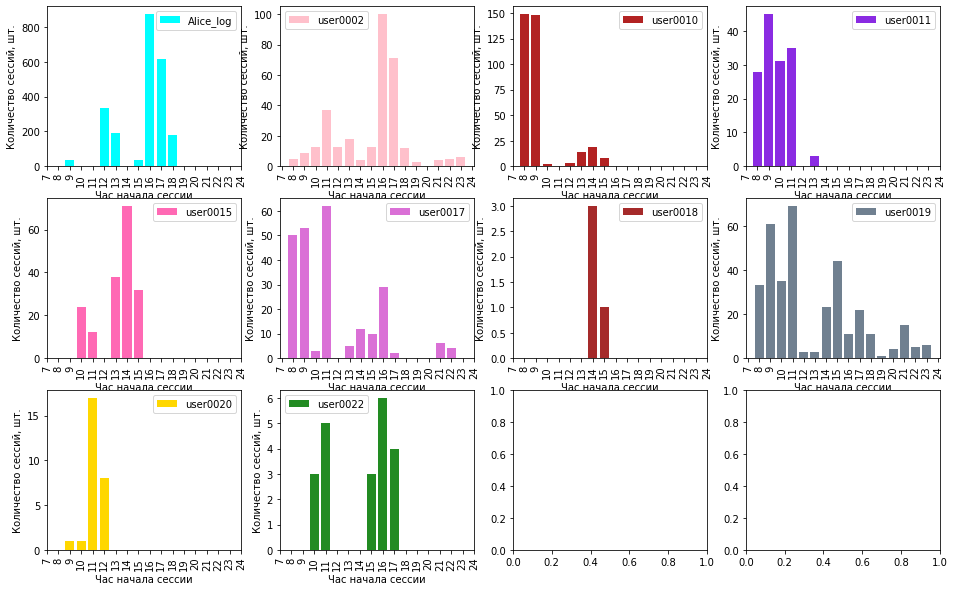

In [287]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.DataFrame.groupby(new_train_data_10users, 'user')): 
    axes[idx // 4][idx % 4].bar(sub_df['start_hour'].value_counts().index, sub_df['start_hour'].value_counts(),
                                color = color_dic[user], label = user)
    axes[idx // 4][idx % 4].legend()
    axes[idx // 4][idx % 4].set_xlabel(u'Час начала сессии')
    axes[idx // 4][idx % 4].set_ylabel(u'Количество сессий, шт.')
    axes[idx // 4][idx % 4].set_xticks([i for i in range(7,25)])
    axes[idx // 4][idx % 4].set_xticklabels([i for i in range(7,25)], rotation=90)

Построим гистограммы распределения числа уникальных сайтов в сессии (#unique_sites) для каждого из 10 пользователей по отдельности

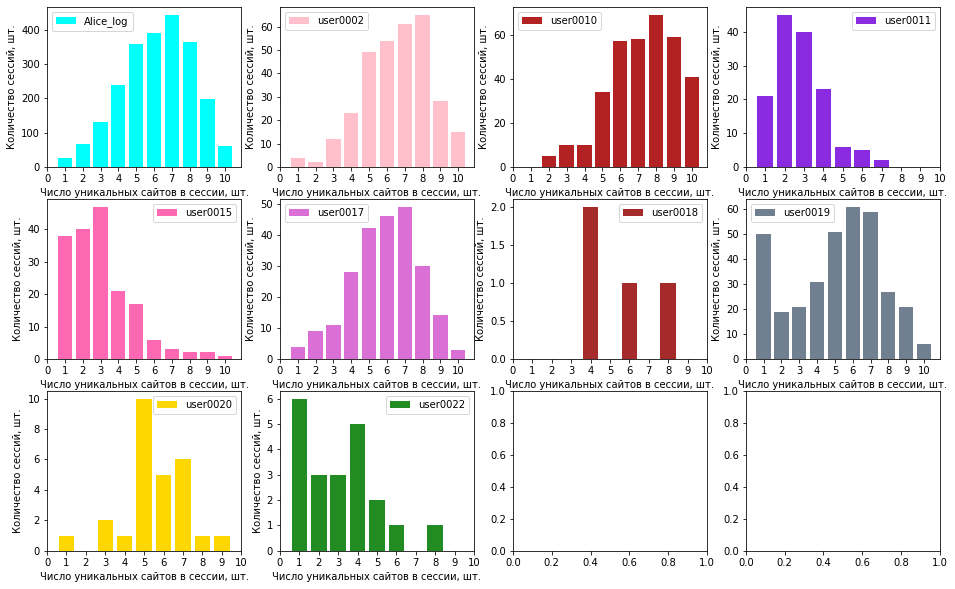

In [284]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.DataFrame.groupby(new_train_data_10users, 'user')): 
    axes[idx // 4][idx % 4].bar(sub_df['#unique_sites'].value_counts().index, sub_df['#unique_sites'].value_counts(), 
                                color = color_dic[user], label = user)
    axes[idx // 4][idx % 4].legend()
    axes[idx // 4][idx % 4].set_xlabel(u'Число уникальных сайтов в сессии, шт.')
    axes[idx // 4][idx % 4].set_ylabel(u'Количество сессий, шт.')
    axes[idx // 4][idx % 4].set_xticks([i for i in range(11)])
    axes[idx // 4][idx % 4].set_xticklabels([i for i in range(11)])

Построим гистограммы распределения среднего времени нахождения на топ-30 сайтах в сессии ('aver_time_top_site_30') для каждого из 10 пользователей по отдельности, ограничев значения по x до 60 с

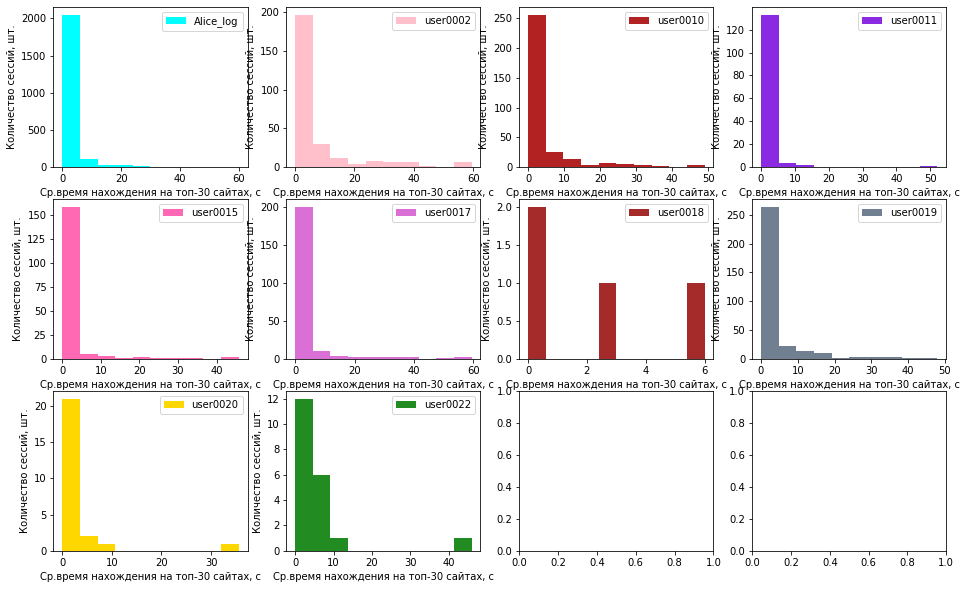

In [299]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.DataFrame.groupby(new_train_data_10users, 'user')): 
    axes[idx // 4][idx % 4].hist(sub_df['aver_time_top_site_30'].loc[sub_df['aver_time_top_site_30'] <= 60], 
                                color = color_dic[user], label = user)
    axes[idx // 4][idx % 4].set_xlabel(u'Ср.время нахождения на топ-30 сайтах, с')
    axes[idx // 4][idx % 4].set_ylabel(u'Количество сессий, шт.')
    axes[idx // 4][idx % 4].legend()

Построим гистограммы распределения суммарной частоты посещения сайтов 's.youtube.com'(80), 'www.youtube.com'(76), 'www.facebook.com'(29), 'www.google.fr'(21), 'twitter.com'(37), 'vk.com'(3000) в сессии (данные сайты входят в топ-30 сайтов по посещяемости Alice)

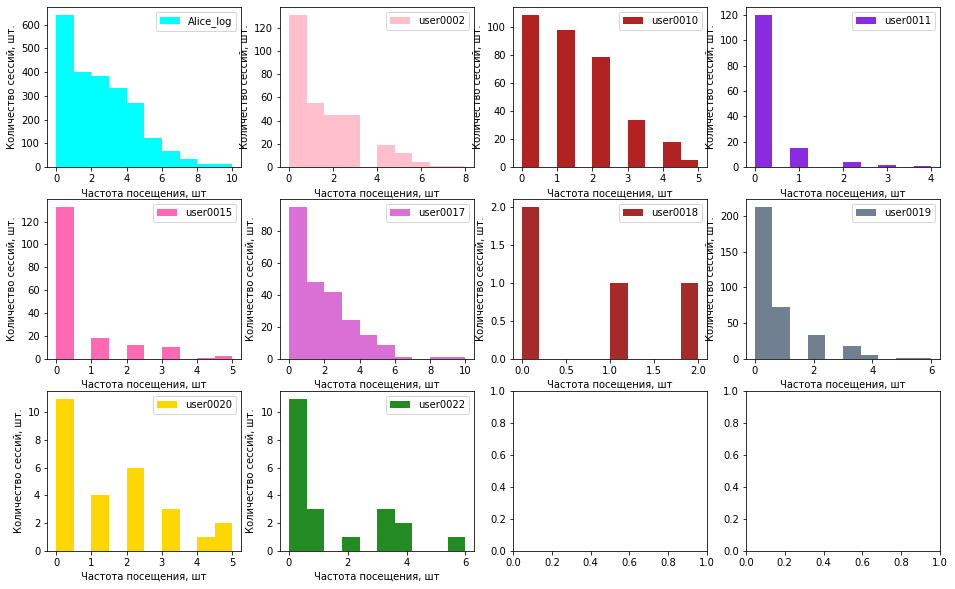

In [300]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

for idx, (user, sub_df) in  enumerate(pd.DataFrame.groupby(new_train_data_10users, 'user')): 
    axes[idx // 4][idx % 4].hist(sub_df['freq_soc_top_sit'], 
                                color = color_dic[user], label = user)
    axes[idx // 4][idx % 4].set_xlabel(u'Частота посещения, шт')
    axes[idx // 4][idx % 4].set_ylabel(u'Количество сессий, шт.')
    axes[idx // 4][idx % 4].legend()

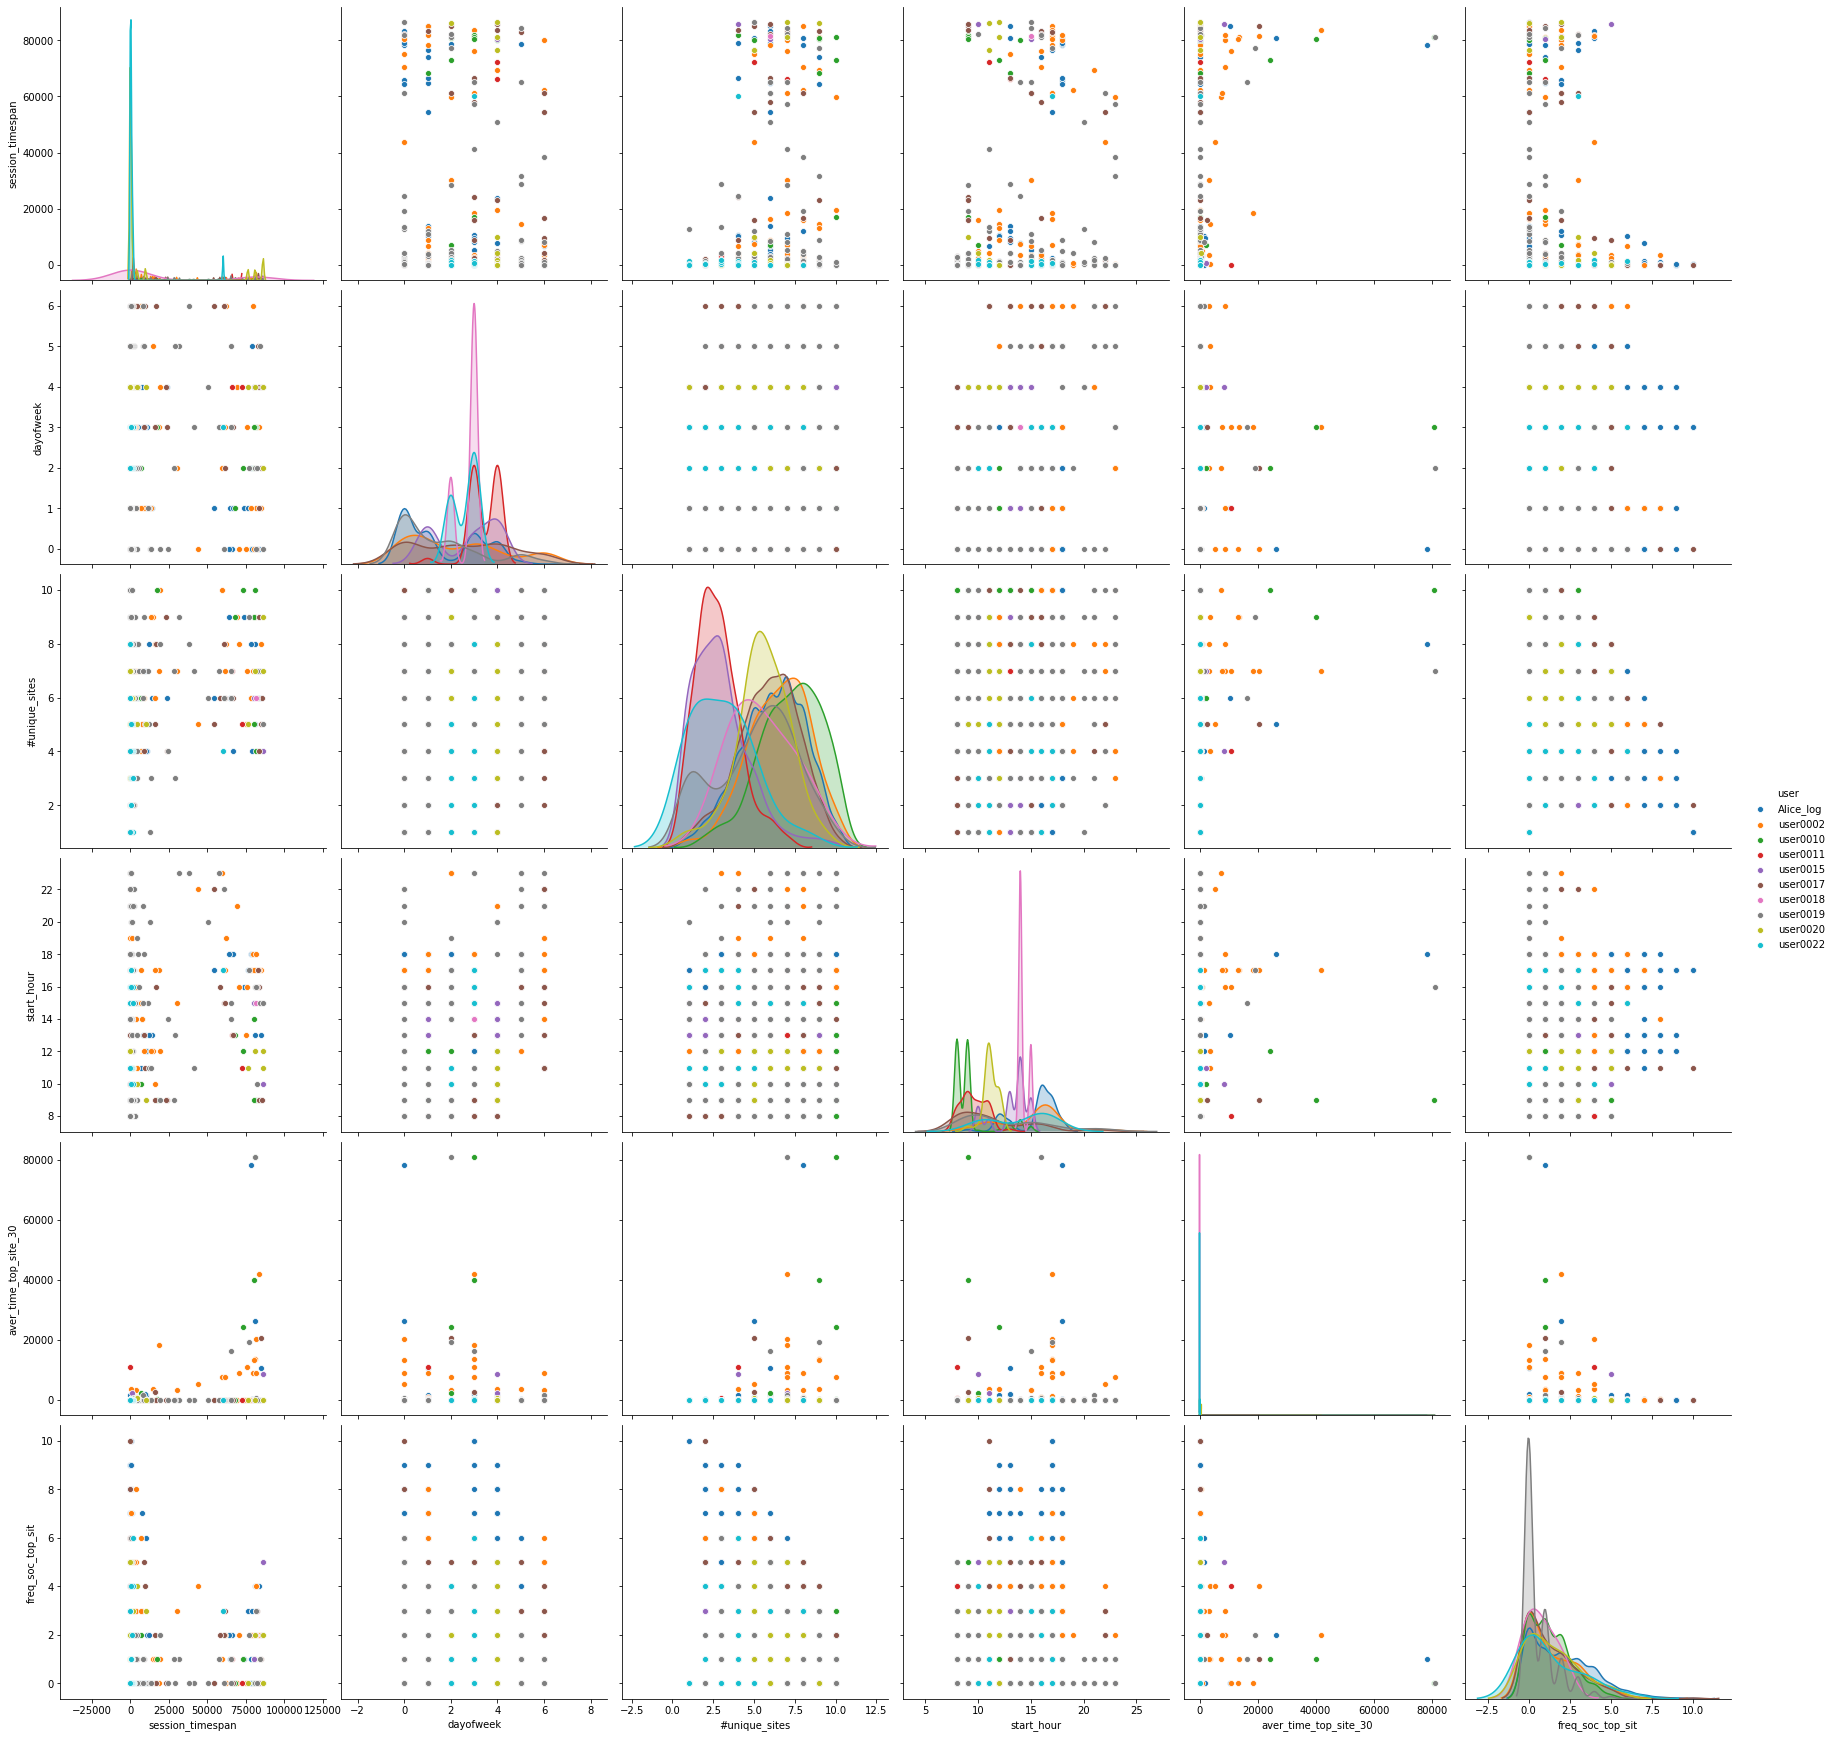

In [301]:
sns.pairplot(new_train_data_10users, hue="user", 
             vars=['session_timespan', 'dayofweek', '#unique_sites', 'start_hour', 'aver_time_top_site_30', 
                   'freq_soc_top_sit'],
             height=4);

### Вывод:

Графики по добавленным признакам в целом отличаются у разных пользователей (за исключением 'aver_time_top_site_30'), в связи с чем данные признаки можно попробовать применить при обучании моделей идентификации пользователя.

### Вернемся обратно к нашим обучающим и тестовым выборкам

Добавим новые признаки к данным:
* session_timespan – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
* dayofweek – день недели начала сессии (то есть день недели в записи минимального timestamp среди десяти)
* start_hour – час начала сессии (то есть час в записи минимального timestamp среди десяти)
* #unique_sites – число уникальных сайтов в сессии
* freq_soc_top_site - суммарная посещаемость сайтов 's.youtube.com'(80), 'www.youtube.com'(76), 'www.facebook.com'(29), 'www.google.fr'(21), 'twitter.com'(37), 'vk.com'(3000) в сессию (данные сайты входят в топ-30 сайтов по посещяемости Alice)

In [330]:
dayofweek = train_test_df_time['time1'].dt.dayofweek
start_hour = train_test_df_time['time1'].dt.hour
session_timespan = np.max(train_test_df_time, axis=1) - np.min(train_test_df_time, axis=1)
session_timespan.replace(np.timedelta64(0, 's'), np.timedelta64(1800, 's'), inplace=True)
session_timespan = session_timespan / np.timedelta64(1, 's')
freq_soc_top_site = np.sum((train_test_df_sites < 31), axis=1)

In [335]:
train_test_df_sites['session_timespan'] = session_timespan
train_test_df_sites['dayofweek'] = dayofweek
train_test_df_sites['start_hour'] = start_hour
train_test_df_sites['#unique_sites'] = unique_sites
train_test_df_sites['freq_soc_top_site'] = freq_soc_top_site
train_test_df_sites['target'] = train_test_df['target']
train_test_df_sites

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,dayofweek,start_hour,#unique_sites,freq_soc_top_site,target
session_id,,,,,,,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0,1800.0,3,10,2,9,0.0
2,890,941,3847,941,942,3846,3847,3846,1516,1518,26.0,5,11,7,0,0.0
3,14769,39,14768,14769,37,39,14768,14768,14768,14768,7.0,0,16,4,0,0.0
4,782,782,782,782,782,782,782,782,782,782,270.0,4,10,1,0,0.0
5,22,177,175,178,177,178,175,177,177,178,246.0,4,10,4,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82793,812,1039,676,0,0,0,0,0,0,0,1800.0,3,18,4,7,NaN
82794,300,302,302,300,300,1222,302,1218,1221,1216,39.0,0,14,6,0,NaN
82795,29,33,35,22,37,6779,30,21,23,6780,8.0,4,11,10,5,NaN


Построим гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*) для Элис (1: 'aqua') и всех других пользователей (0: 'darkviolet') и 

In [339]:
color_dic = {0: 'darkviolet', 1: 'aqua'}
list_labels = ['Another users', 'Alice']

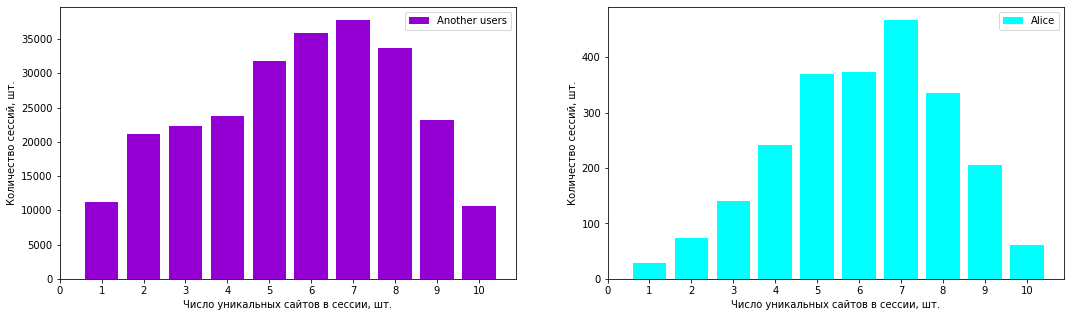

In [340]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 5))

for idx, (user, sub_df) in  enumerate(pd.DataFrame.groupby(train_test_df_sites, 'target')): 
    axes[idx].bar(sub_df['#unique_sites'].value_counts().index, sub_df['#unique_sites'].value_counts(), 
                                color = color_dic[user], label = list_labels[idx])
    axes[idx].legend()
    axes[idx].set_xlabel(u'Число уникальных сайтов в сессии, шт.')
    axes[idx].set_ylabel(u'Количество сессий, шт.')
    axes[idx].set_xticks([i for i in range(11)])
    axes[idx].set_xticklabels([i for i in range(11)])

Построим гистограмму распределения часа начала сессии (*start_hour*) для Элис (1: 'aqua') и всех других пользователей (0: 'darkviolet')

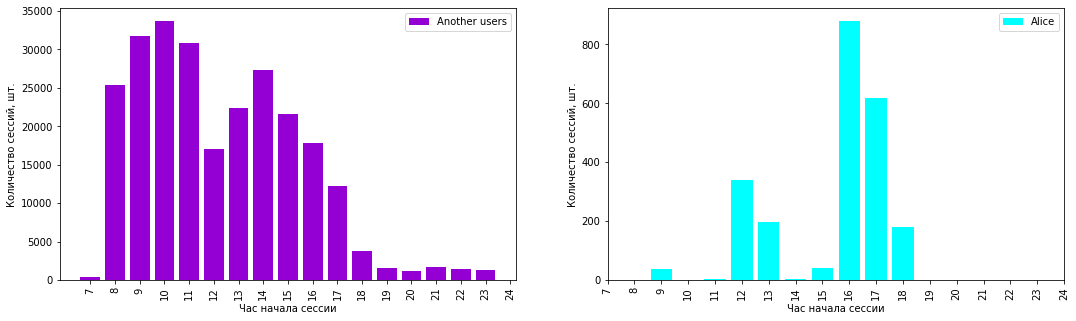

In [341]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 5))

for idx, (user, sub_df) in  enumerate(pd.DataFrame.groupby(train_test_df_sites, 'target')): 
    axes[idx].bar(sub_df['start_hour'].value_counts().index, sub_df['start_hour'].value_counts(), 
                                color = color_dic[user], label = list_labels[idx])
    axes[idx].legend()
    axes[idx].set_xlabel(u'Час начала сессии')
    axes[idx].set_ylabel(u'Количество сессий, шт.')
    axes[idx].set_xticks([i for i in range(7,25)])
    axes[idx].set_xticklabels([i for i in range(7,25)], rotation=90)

Построим гистограмму распределения дня недели, в который началась сессия (*dayofweek*) для Элис (1: 'aqua') и всех других пользователей (0: 'darkviolet') и 

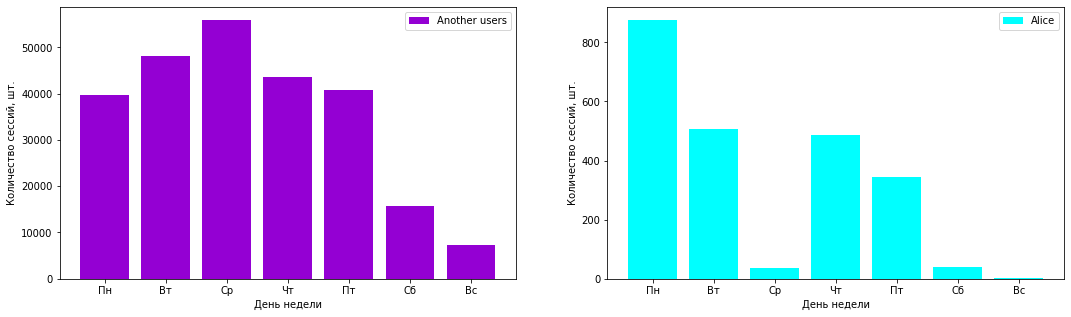

In [342]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 5))
days_of_week = [u'Пн', u'Вт', u'Ср', u'Чт', u'Пт', u'Сб', u'Вс']

for idx, (user, sub_df) in  enumerate(pd.DataFrame.groupby(train_test_df_sites, 'target')): 
    axes[idx].bar(sub_df['dayofweek'].value_counts().index, sub_df['dayofweek'].value_counts(), 
                                color = color_dic[user], label = list_labels[idx])
    axes[idx].legend()
    axes[idx].set_xlabel(u'День недели')
    axes[idx].set_ylabel(u'Количество сессий, шт.')
    axes[idx].set_xticks(range(7))
    axes[idx].set_xticklabels(days_of_week)

Для возможности учета продолжительности сессии (*session_timespan*) в задаче классификации, разобъем время сессии на интервалы от 0 до 10, от 10 до 20, от 20 до 40, от 40 до 80, от 80 до 200 и более 200 сек.

In [343]:
def type_session_timespan(x):
    if (x <= 10):
        return 1
    elif (x > 10) and (x <= 20 ):
        return 2
    elif (x > 20) and (x <= 40):
        return 3
    elif (x > 40) and (x <= 80) :
        return 4
    elif (x > 80) and (x <= 200):
        return 5
    else:
        return 6

In [344]:
train_test_df_sites['session_timespan_class'] = session_timespan.apply(type_session_timespan)

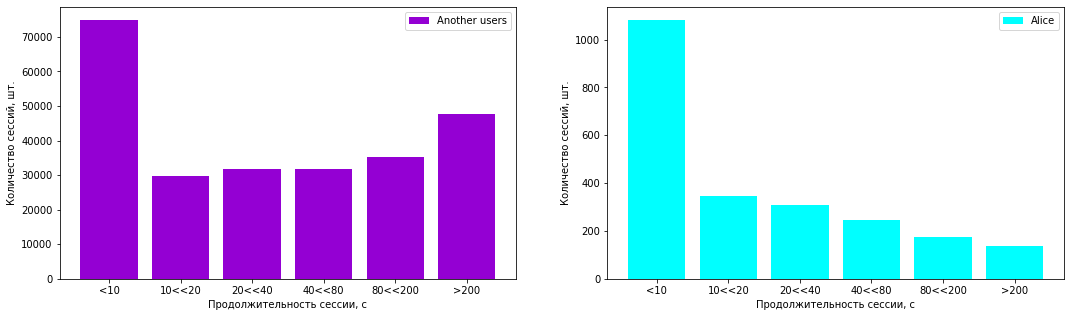

In [346]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 5))
tst = [u'<10', u'10<<20', u'20<<40', u'40<<80', u'80<<200', u'>200']

for idx, (user, sub_df) in  enumerate(pd.DataFrame.groupby(train_test_df_sites, 'target')): 
    axes[idx].bar(sub_df['session_timespan_class'].value_counts().index, sub_df['session_timespan_class'].value_counts(), 
                                color = color_dic[user], label = list_labels[idx])
    axes[idx].legend()
    axes[idx].set_xlabel(u'Продолжительность сессии, с')
    axes[idx].set_ylabel(u'Количество сессий, шт.')
    axes[idx].set_xticks(range(1,7))
    axes[idx].set_xticklabels(tst)

In [347]:
train_test_df_sites

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,session_timespan,dayofweek,start_hour,#unique_sites,freq_soc_top_site,target,session_timespan_class
session_id,,,,,,,,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0,1800.0,3,10,2,9,0.0,6
2,890,941,3847,941,942,3846,3847,3846,1516,1518,26.0,5,11,7,0,0.0,3
3,14769,39,14768,14769,37,39,14768,14768,14768,14768,7.0,0,16,4,0,0.0,1
4,782,782,782,782,782,782,782,782,782,782,270.0,4,10,1,0,0.0,6
5,22,177,175,178,177,178,175,177,177,178,246.0,4,10,4,1,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82793,812,1039,676,0,0,0,0,0,0,0,1800.0,3,18,4,7,NaN,6
82794,300,302,302,300,300,1222,302,1218,1221,1216,39.0,0,14,6,0,NaN,3
82795,29,33,35,22,37,6779,30,21,23,6780,8.0,4,11,10,5,NaN,1


## 3) Подготовка данных

Для рассматриваемой задачи классификации создадим разреженные матрицы (идея мешка слов), в которых строкам будут соответствовать сессии из 10 сайтов, а столбцам – индексы сайтов. В сессиях меньше 10 сайтов у нас остались нули, так что первый признак (сколько раз попался 0) по смыслу отличен от остальных (сколько раз попался сайт с индексом  𝑖 ), поэтому первый столбец разреженной матрицы будет удален.

In [348]:
def func_csr_matrix(data_for_m):
    docs = data_for_m.iloc[:, :].values
    indptr = [0]
    indices = []
    data = []
    vocabulary = {}

    for d in docs:
        for t in d:
            index = vocabulary.setdefault(t, t)
            indices.append(index)
            data.append(1)    
        indptr.append(len(indices))
    
    return csr_matrix((data, indices, indptr), dtype=int)[:, 1:]

In [349]:
train_test_sparse = func_csr_matrix(train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')).astype('uint8')

In [350]:
X_train_sparse = train_test_sparse[:train_df.shape[0],:]
X_test_sparse = train_test_sparse[-test_df.shape[0]:,:]
y = train_df['target'].values

Добавим к разреженным матрицам признаки:
- `session_timespan_class` – номер интервала времени куда попадает продолжительность рассматриваемой сессии
- `dayofweek` – день недели начала сессии (то есть день недели в записи минимального timestamp среди десяти)
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `#unique_sites` – число уникальных сайтов в сессии
- `freq_soc_top_site` - суммарная посещаемость сайтов 's.youtube.com'(80), 'www.youtube.com'(76), 'www.facebook.com'(29), 'www.google.fr'(21), 'twitter.com'(37), 'vk.com'(3000) в сессии

предварительно подготових их, разделив рассматриваемые категориальные признаки на единичные вектора

In [351]:
from sklearn.preprocessing import OneHotEncoder

In [352]:
one_hot = OneHotEncoder()

In [355]:
da = dayofweek.values.reshape((-1, 1))
sa = start_hour.values.reshape((-1, 1))
usa = unique_sites.values.reshape((-1, 1))
stc = train_test_df_sites['session_timespan_class'].values.reshape((-1, 1))
fsta = freq_soc_top_site.values.reshape((-1, 1))

In [356]:
da = one_hot.fit_transform(da)
sa = one_hot.fit_transform(sa)
usa = one_hot.fit_transform(usa)
stc = one_hot.fit_transform(stc)
fsta = one_hot.fit_transform(fsta)

In [357]:
from scipy.sparse import hstack

In [371]:
X_train_sparse_dop_feat = hstack([X_train_sparse, da[:train_df.shape[0]], 
                                  sa[:train_df.shape[0]], 
                                  usa[:train_df.shape[0]],
                                 stc[:train_df.shape[0]],
                                 fsta[:train_df.shape[0]]]).tocsr()

In [373]:
X_test_sparse_dop_feat = hstack([X_test_sparse, da[-test_df.shape[0]:], 
                                  sa[-test_df.shape[0]:],
                                 usa[-test_df.shape[0]:],
                                stc[-test_df.shape[0]:],
                                fsta[-test_df.shape[0]:]]).tocsr()

### 4) Обучение моделей

Разобьем обучающую выборку на 2 части в пропорции 7/3, причем не перемешивая. Исходные данные упорядочены по времени, тестовая выборка по времени четко отделена от обучающей

In [374]:
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse_dop_feat[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse_dop_feat[train_share:, :], y[train_share:]

Ввиду большого объема данных примением SGD-классификатор, фунция потерь - логистическая, ввиду необходимости выдачи вероятностных предсказаний.

In [375]:
sgd_logit = SGDClassifier(loss='log', n_jobs=-1)

Обучим модель

In [376]:
sgd_logit.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Сделаем прогноз в виде предсказанных вероятностей того, что это сессия Элис, на отложенной выборке *(X_valid, y_valid)*

In [377]:
pred_proba = sgd_logit.predict_proba(X_valid)
print(pred_proba)

[[9.87631881e-01 1.23681190e-02]
 [9.99913980e-01 8.60197449e-05]
 [9.99965128e-01 3.48719380e-05]
 ...
 [9.97193396e-01 2.80660409e-03]
 [9.99979121e-01 2.08789190e-05]
 [9.96542394e-01 3.45760608e-03]]


Посчитаем ROC AUC логистической регрессии, обученной с помощью стохастического градиентного спуска, на отложенной выборке

In [378]:
auc = roc_auc_score(y_true = y_valid, y_score = pred_proba[:,1])
print(auc)

0.9725257532061765


In [379]:
from sklearn import metrics

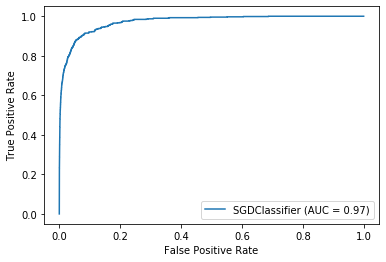

In [380]:
metrics.plot_roc_curve(sgd_logit, X_valid, y_valid)

Подберем гиперпараметр alpha с использованием поисковой сетки кросс-валидации GridSearchCV. Метрика качества площадь под ROC-кривой (roc_auc) применяемая для бинарных классификаций

In [381]:
from sklearn.model_selection import GridSearchCV

Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV

In [382]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

In [383]:
parameters_grid = {
    'alpha' : np.linspace(0.000001, 0.01, num = 40),
}

In [384]:
%%time
grid_cv = GridSearchCV(sgd_logit, parameters_grid, scoring='roc_auc', n_jobs=-1, return_train_score=True)
grid_cv.fit(X_train_sparse_dop_feat, y)
grid_cv.best_score_

Wall time: 24.3 s


0.9849436984282633

Нарисуйте график кросс-валидации зависимости `ROC AUC` от `alpha`.

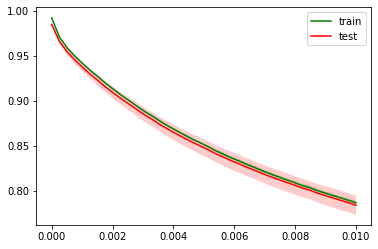

In [385]:
plot_validation_curves(parameters_grid['alpha'], grid_cv.cv_results_)

из графика видно, что с уменьшением параметра alpha, метрика ROC AUC увеличивается

Построим кривые обучения

In [386]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

Посчитаем доли правильных ответов на кросс-валидации в рассматриваемой задаче от размера выборки

In [387]:
from sklearn.model_selection import learning_curve

In [388]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = grid_cv.best_estimator_
n_train, val_train, val_test = learning_curve(estimator=estimator, X=X_train_sparse_dop_feat, y=y)

Wall time: 19.3 s


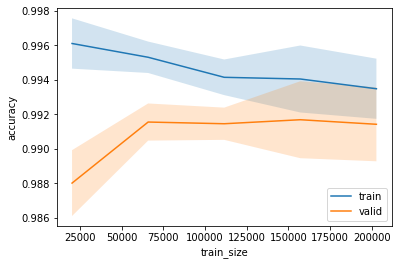

In [389]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

Из полученного графика следует, что при добавлении новых размеченных данных при той же постановке задачи, точность модели можно улучшить

Подготовим результаты для загрузки на <a href="https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2">Kaggle</a>:

In [390]:
res = grid_cv.best_estimator_.predict_proba(X_test_sparse_dop_feat)

In [391]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [392]:
write_to_submission_file(predicted_labels=res[:,1], out_file="[YDF & MIPT] Coursera_OorzhakAU.csv")

<font color='green'>**Оценка при прогнозе с использованием SGDCLassifer c функцией потерь "Log"**</font>

**Name:** YDF MIPT Coursera_OorzhakAU.csv **Score:** 0.93247

Уберем одиночные вектора отвечающие за время продолжительности сессии

In [393]:
X_train_sparse_dop_feat = hstack([X_train_sparse, da[:train_df.shape[0]], 
                                  sa[:train_df.shape[0]], 
                                  usa[:train_df.shape[0]],
                                 fsta[:train_df.shape[0]]]).tocsr()

In [394]:
X_test_sparse_dop_feat = hstack([X_test_sparse, da[-test_df.shape[0]:], 
                                  sa[-test_df.shape[0]:],
                                 usa[-test_df.shape[0]:],
                                fsta[-test_df.shape[0]:]]).tocsr()

In [395]:
%%time
grid_cv = GridSearchCV(sgd_logit, parameters_grid, scoring='roc_auc', n_jobs=-1)
grid_cv.fit(X_train_sparse_dop_feat, y)

Wall time: 23.6 s


GridSearchCV(cv=None, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='log', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=-1,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0.1, v...
       5.12869231e-03, 5.38507692e-03, 5.64146154e-03, 5.89784615e-03,
       6.15423077e-03, 6.41061538e-03, 6.66700000e-03, 6.92338462e-03,
       7.17976923e-03, 7.43615385e-03, 7.69253846e-03, 7.94892308e-03,
       8.20530769e-03, 8.46169231e-03, 8.71807692e-03, 8.97446154e-03,
       9.23084615e-03, 9.4872307

In [396]:
from sklearn.metrics import classification_report

In [397]:
print(classification_report(y, grid_cv.best_estimator_.predict(X_train_sparse_dop_feat)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    251264
           1       0.75      0.55      0.63      2297

    accuracy                           0.99    253561
   macro avg       0.87      0.77      0.81    253561
weighted avg       0.99      0.99      0.99    253561



In [398]:
res = grid_cv.best_estimator_.predict_proba(X_test_sparse_dop_feat)

In [399]:
write_to_submission_file(predicted_labels=res[:,1], out_file="[YDF & MIPT] Coursera_OorzhakAU.csv")

<font color='green'>**Оценка при прогнозе с использованием SGDCLassifer c функцией потерь "Log"**</font>

**Name:** YDF MIPT Coursera_OorzhakAU.csv **Score:** 0.93906

Метрика площади под кривой для подготовленой модели (ROC AUC) составила порядка 0.94.
Точности распознания Элис составила менее 0,80 (precision), а полнота (recall) менее 0,60.

Рассматриваемую модель можно улучшить с добавлением новых признаков и объема обучающей выборки.